# Recommenders

## Import Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models, callbacks

import os
from PIL import Image

import transformers


from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

E:\Anaconda3\envs\py310-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

## Data

In [3]:
df_train = pd.read_csv('DATA/train.csv')
df_nominated = pd.read_csv('DATA/nominated_p_ids.csv',index_col=0)
df_test = pd.read_csv('DATA/test_ids.csv')
df_id2feat = pd.read_csv('DATA/id2feat2.csv', index_col=0)
df_id2feat

title         id  \
350                                 گوشی موبایل نوکیا 1280      350.0   
1895                                  ماوس لاجیتک مدل M100     1895.0   
2739                 کارت شبکه بی‌سیم تی پی-لینک TL-WN821N     2739.0   
2746            کارت شبکه بی‌سیم تی پی-لینک مدل TL-WN781ND     2746.0   
2747       کارت شبکه USB و بی‌سیم تی پی-لینک مدل TL-WN722N     2747.0   
...                                                    ...        ...   
2071563  کرم مرطوب‎ کننده فیس دوکس مدل هیدرازوم حجم ۷۵ ...  2071563.0   
2071605                         کاغذ پرینتر حرارتی مدل NCR  2071605.0   
2071615  کرم مرطوب ‎کننده فیس دوکس مدل hydrasome intens...  2071615.0   
2072202                         سلفون مدل M11 رول 500 متری  2072202.0   
2072238                          مانیتور خودرو مدل MON-150  2072238.0   

         category    brand is_premium is_miscellaneous  r_rate  r_count  \
350          11.0     20.0      False            False    96.0     50.0   
1895         26.0     38.0      False            False    82.0    344.0   
2739         67.0     72.0      False            False    84.0    340.0   
2746         67.0     72.0      False            False    82.0    333.0   
2747         67.0     72.0      False            False    86.0    534.0   
...           ...      ...        ...              ...     ...      ...   
2071563    6489.0  13898.0      False            False    86.0    315.0   
2071605    5960.0    719.0      False            False    70.0     96.0   
2071615    6489.0  13898.0      False            False    86.0    926.0   
2072202    6757.0    719.0      False            False    74.0   1020.0   
2072238    5928.0    719.0      False            False    82.0     41.0   

        is_fake is_jet is_med           badges colors has_size_guide  \
350       False  False  False           78,52,    NaN          False   
1895      False  False  False  23,78,52,41,69,     1,          False   
2739      False  False  False        78,42,67,    NaN          False   
2746      False  False  False     14,79,42,68,    NaN          False   
2747      False  False  False  16,80,52,42,68,    NaN          False   
...         ...    ...    ...              ...    ...            ...   
2071563   False  False  False        19,78,41,    NaN          False   
2071605   False  False  False     23,74,42,70,    NaN          False   
2071615   False  False  False        23,78,42,    NaN          False   
2072202   False  False  False        78,42,65,    35,          False   
2072238   False  False  False     78,52,40,65,    NaN          False   

              price  
350             NaN  
1895      3800000.0  
2739      5400000.0  
2746      4200000.0  
2747      5850000.0  
...             ...  
2071563   1388000.0  
2071605   1400000.0  
2071615   1371000.0  
2072202   1457000.0  
2072238  29500000.0  

[70518 rows x 15 columns]

In [6]:
a = df_id2feat.loc[df_test.source_product_id]
b = df_id2feat.loc[df_nominated.rel_product_id]

In [12]:
a

title          id  \
2747        کارت شبکه USB و بی‌سیم تی پی-لینک مدل TL-WN722N      2747.0   
5289      مودم روتر ADSL2 Plus بی‌سیم N300 دی-لینک مدل D...      5289.0   
5289      مودم روتر ADSL2 Plus بی‌سیم N300 دی-لینک مدل D...      5289.0   
26237     ماشین اصلاح صورت پاناسونیک سری لمدش مدل لمدش E...     26237.0   
26701                           پلوپز پارس خزر مدل DMC-181P     26701.0   
...                                                     ...         ...   
12143680                     ماوس بی سیم بیاند مدل BM-171RF  12143680.0   
12180235                     هندزفری بلوتوثی لیتو مدل LB-05  12180235.0   
12305148                         ابزار شوخی مدل تابوت متحرک  12305148.0   
12456191                هارد کیس گیتار کلاسیک مدل چرمی رمزی  12456191.0   
12557210  پاوربانک انکر مدل 347PowerCore 40K A1377H11 ظر...  12557210.0   

          category    brand is_premium is_miscellaneous  r_rate  r_count  \
2747          67.0     72.0      False            False    86.0    534.0   
5289        5721.0     43.0      False            False    84.0   2516.0   
5289        5721.0     43.0      False            False    84.0   2516.0   
26237       6085.0     16.0      False            False    82.0    682.0   
26701       5792.0   1090.0      False            False    78.0    370.0   
...            ...      ...        ...              ...     ...      ...   
12143680      26.0   2843.0      False            False    80.0    118.0   
12180235     211.0  23635.0      False            False    78.0    131.0   
12305148    6083.0    719.0      False            False     0.0      0.0   
12456191    6235.0    719.0      False            False    80.0      1.0   
12557210    1272.0   1742.0      False            False    76.0      4.0   

         is_fake is_jet is_med           badges colors has_size_guide  \
2747       False  False  False  16,80,52,42,68,    NaN          False   
5289       False  False  False     21,80,42,68,     2,          False   
5289       False  False  False     21,80,42,68,     2,          False   
26237      False  False  False     15,80,42,64,     1,          False   
26701      False  False  False        80,42,68,     2,          False   
...          ...    ...    ...              ...    ...            ...   
12143680   False  False  False     23,48,52,70,     1,          False   
12180235   False  False  False              68,    NaN          False   
12305148   False  False  False              52,     1,          False   
12456191   False  False  False              NaN    NaN          False   
12557210   False  False  False           53,63,     1,          False   

               price  
2747       5850000.0  
5289      13403000.0  
5289      13403000.0  
26237     45400000.0  
26701     36100000.0  
...              ...  
12143680   2550000.0  
12180235         NaN  
12305148  48000000.0  
12456191  19000000.0  
12557210  41900000.0  

[24702 rows x 15 columns]

In [11]:
b#.loc[b.category==67]

title          id  \
2025918      کارت شبکه بی‌سیم تی پی-لینک مدل TL-WN722N_V3.0   2025918.0   
92440     مودم روتر ADSL2 Plus بی‌سیم N300 دی-لینک مدل D...     92440.0   
3217179          مودم روتر ADSL2 Plus بی سیم یوتل مدل A304    3217179.0   
2783879               ماشین اصلاح موی صورت کیمی مدل KM-6558   2783879.0   
1657815                    پلوپز پارس خزر مدل Kanduj 101TSP   1657815.0   
...                                                     ...         ...   
2047958                                ماوس تسکو مدل TM-300   2047958.0   
12042091                             هندزفری لیتو مدل LE-17  12042091.0   
11430852        ابزار شوخی مدل میخ فرو رفته در دست کد 2040A  11430852.0   
7998573                              هارد کیس گیتار مدل 001   7998573.0   
9219863    پاوربانک هوکو مدل J87A PD+QC3.0 20W ظرفیت 200...   9219863.0   

          category    brand is_premium is_miscellaneous  r_rate  r_count  \
2025918       67.0     72.0      False            False    88.0    299.0   
92440       5721.0     43.0      False            False    82.0    494.0   
3217179     5721.0   7531.0      False            False    86.0    664.0   
2783879     6085.0   4832.0      False            False    78.0    228.0   
1657815     5792.0   1090.0      False            False    86.0    285.0   
...            ...      ...        ...              ...     ...      ...   
2047958       26.0     56.0      False            False    84.0    335.0   
12042091     211.0  23635.0      False            False    82.0    510.0   
11430852    6083.0    719.0      False            False    52.0      9.0   
7998573     6235.0    719.0      False            False    98.0     10.0   
9219863     1272.0    242.0      False            False   100.0      2.0   

         is_fake is_jet is_med           badges colors has_size_guide  \
2025918    False  False  False     23,79,40,68,    NaN          False   
92440      False  False  False  15,80,52,42,68,     1,          False   
3217179    False  False  False     25,80,42,69,     2,          False   
2783879    False  False  False     14,79,41,66,    NaN          False   
1657815    False  False  False     15,79,42,65,    NaN          False   
...          ...    ...    ...              ...    ...            ...   
2047958    False  False  False        78,40,68,    NaN          False   
12042091   False  False  False              72,   1,2,          False   
11430852   False  False  False           52,63,   3,2,          False   
7998573    False  False  False              63,    NaN          False   
9219863    False  False  False              NaN   2,1,          False   

               price  
2025918    5300000.0  
92440     16119000.0  
3217179    9000000.0  
2783879          NaN  
1657815          NaN  
...              ...  
2047958          NaN  
12042091   1150000.0  
11430852    546500.0  
7998573    6150000.0  
9219863   12720000.0  

[24702 rows x 15 columns]

In [15]:
df_test['rel_product_id'] = df_nominated.values

In [17]:
df_test.to_csv('result.csv')

In [18]:
df_test

source_product_id  rel_product_id
0                   2747         2025918
1                   5289           92440
2                   5289         3217179
3                  26237         2783879
4                  26701         1657815
...                  ...             ...
24697           12143680         2047958
24698           12180235        12042091
24699           12305148        11430852
24700           12456191         7998573
24701           12557210         9219863

[24702 rows x 2 columns]

In [19]:
pd.read_csv('result.csv')

Unnamed: 0  source_product_id  rel_product_id
0               0               2747         2025918
1               1               5289           92440
2               2               5289         3217179
3               3              26237         2783879
4               4              26701         1657815
...           ...                ...             ...
24697       24697           12143680         2047958
24698       24698           12180235        12042091
24699       24699           12305148        11430852
24700       24700           12456191         7998573
24701       24701           12557210         9219863

[24702 rows x 3 columns]

In [3]:
nan_index = df_id2feat.loc[df_id2feat.iloc[:, 1:].isna().all(axis=1)].index
prob = []
for i in df_nominated.rel_product_id:
    if i in nan_index:
        prob.append(i)

In [4]:
len(prob)

28

In [5]:
df_id2feat.loc[df_id2feat.id != df_id2feat.index]

title         id  \
2077127  محافظ صفحه نمایش کولینگ مدل Olka glass مناسب ب...  7040503.0   
2078711            چوب بستنی پهن مدل P3001_01 بسته 40 عددی  1447571.0   
2079555                         استند لوازم آرایشی مدل 175  9287283.0   
2101614  رژ لب جامد مای سری Black Diamond مدل Stay Matt...   386035.0   
2110364             روان نویس زبرا مدل Sarasa0.7 کد 90916   6460109.0   
...                                                    ...        ...   
1982171                                                NaN        NaN   
2028212  فوم اصلاح کاسپین مدل Sensitive Skin حجم 200 می...  2714745.0   
125987   اسپری حالت دهنده مو آرکیا مدل Extra حجم 500 می...  3498910.0   
2051156  شامپو تقویت کننده درمالیفت مدل ویتا گرو حجم 20...  1550654.0   
2053317                                                NaN        NaN   

         category    brand is_premium is_miscellaneous  r_rate  r_count  \
2077127      76.0  30621.0      False            False    80.0     25.0   
2078711    8397.0    719.0      False            False    76.0   3620.0   
2079555    6484.0    719.0      False            False    66.0      3.0   
2101614    6463.0   1847.0      False            False    74.0    135.0   
2110364    5980.0   1141.0      False            False    86.0     80.0   
...           ...      ...        ...              ...     ...      ...   
1982171       NaN      NaN        NaN              NaN     NaN      NaN   
2028212    6530.0  31246.0      False            False    86.0   3573.0   
125987     6621.0  20050.0      False            False    84.0     61.0   
2051156    6518.0  11217.0      False            False    84.0   3343.0   
2053317       NaN      NaN        NaN              NaN     NaN      NaN   

        is_fake is_jet is_med           badges  \
2077127   False  False  False              64,   
2078711   False  False  False     27,80,42,72,   
2079555   False  False  False              63,   
2101614   False  False  False           78,42,   
2110364   False  False  False     16,44,39,70,   
...         ...    ...    ...              ...   
1982171     NaN    NaN    NaN              NaN   
2028212   False  False  False     26,80,52,42,   
125987    False  False  False  23,45,74,38,69,   
2051156   False  False  False     25,80,52,42,   
2053317     NaN    NaN    NaN              NaN   

                                                    colors has_size_guide  \
2077127                                              56,1,          False   
2078711                                                NaN          False   
2079555                                                15,          False   
2101614                                                NaN          False   
2110364  3,26,46,42,7,14,1,17,11,6,54,80,9,8,155,44,4,7...          False   
...                                                    ...            ...   
1982171                                                NaN            NaN   
2028212                                                NaN          False   
125987                                                 NaN          False   
2051156                                                NaN          False   
2053317                                                NaN            NaN   

             price  
2077127   324800.0  
2078711   205000.0  
2079555  5000000.0  
2101614  2137100.0  
2110364   480000.0  
...            ...  
1982171        NaN  
2028212   635000.0  
125987    780000.0  
2051156   765000.0  
2053317        NaN  

[2475 rows x 15 columns]

### Preprocess

In [6]:
df_id2feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70518 entries, 350 to 2072238
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             70389 non-null  object 
 1   id                70389 non-null  float64
 2   category          70389 non-null  float64
 3   brand             70378 non-null  float64
 4   is_premium        70378 non-null  object 
 5   is_miscellaneous  70378 non-null  object 
 6   r_rate            70389 non-null  float64
 7   r_count           70389 non-null  float64
 8   is_fake           70384 non-null  object 
 9   is_jet            70384 non-null  object 
 10  is_med            70384 non-null  object 
 11  badges            63651 non-null  object 
 12  colors            30552 non-null  object 
 13  has_size_guide    70386 non-null  object 
 14  price             55870 non-null  float64
dtypes: float64(6), object(9)
memory usage: 8.6+ MB


In [7]:
df_id2feat.isna().sum(axis=0)/df_id2feat.shape[0]

title               0.001829
id                  0.001829
category            0.001829
brand               0.001985
is_premium          0.001985
is_miscellaneous    0.001985
r_rate              0.001829
r_count             0.001829
is_fake             0.001900
is_jet              0.001900
is_med              0.001900
badges              0.097379
colors              0.566749
has_size_guide      0.001872
price               0.207720
dtype: float64

In [8]:
df_id2feat.loc[10031140]

title               خودکار مدل پاک کن دار  طرح خرسی
id                                       10031140.0
category                                     5980.0
brand                                         719.0
is_premium                                    False
is_miscellaneous                              False
r_rate                                         86.0
r_count                                        16.0
is_fake                                       False
is_jet                                        False
is_med                                        False
badges                                       16,67,
colors                                   4,1,9,131,
has_size_guide                                False
price                                      450000.0
Name: 10031140, dtype: object

In [9]:
imputer = KNNImputer(n_neighbors=5)
encoder = LabelEncoder()
normalizer = StandardScaler()
minMax = MinMaxScaler()

In [10]:
def get_ids(d, id_list):
    for i in d.split(',')[:-1]:
            id_list.append(i)
            
def set_id_cols(series, id_list):
    new_cols = pd.DataFrame(index = series.index, columns=id_list)
    for idx, s in zip(series.index, series):
        for i in s.split(',')[:-1]:
            new_cols.loc[idx, i] = True
    
    return new_cols

In [11]:
# df_id2feat[['badges', 'colors']] = df_id2feat[['badges', 'colors']].fillna('0,')
df_id2feat[['is_premium','is_miscellaneous','is_fake','is_jet','is_med','has_size_guide']] = df_id2feat[['is_premium','is_miscellaneous','is_fake','is_jet','is_med','has_size_guide']].fillna(False)
df_id2feat[['category','brand']] = df_id2feat[['category','brand']].fillna(0)
df_id2feat.loc[df_id2feat.id.isna(), 'id'] = df_id2feat.loc[df_id2feat.id.isna(), 'id'].index
df_id2feat[['r_rate','r_count']] = df_id2feat[['r_rate','r_count']].fillna((df_id2feat[['r_rate','r_count']].mean(axis=0)))
df_id2feat[['title']] = df_id2feat[['title']].fillna('empty')

df_id2feat.drop(['badges', 'colors', 'title'], axis=1, inplace=True)

# color_ids = []
# df_id2feat.colors.apply(lambda x:get_ids(x, color_ids))

# badge_ids = []
# df_id2feat.badges.apply(lambda x:get_ids(x, badge_ids))
price = imputer.fit_transform(df_id2feat.iloc[:,1:])[:,-1]
df_id2feat.price = price

encoder = LabelEncoder()
df_id2feat.category = encoder.fit_transform(df_id2feat.category)
encoder = LabelEncoder()
df_id2feat.brand = encoder.fit_transform(df_id2feat.brand)

df_id2feat.iloc[:,4:] = normalizer.fit_transform(df_id2feat.iloc[:,4:])
df_id2feat.iloc[:,0:1] = minMax.fit_transform(df_id2feat.iloc[:,0:1])



In [12]:
# err = []
# for i in tqdm(os.listdir('DATA/Images/')):
#     if np.asarray(Image.open(f'DATA/Images/{i}')).sum() != 0:
#         if df_id2feat.loc[int(i.split('.')[0]), 'category'] == 0:
#             err.append(i)

In [13]:
# len(err)

In [14]:
df_id2feat.isna().any().any()

False

In [23]:
df_id2feat

id  category  brand  is_premium  is_miscellaneous    r_rate  \
350      0.000000         1     15       False         -0.009225  0.985368   
1895     0.000116         8     29       False         -0.009225  0.223893   
2739     0.000180        33     50       False         -0.009225  0.332675   
2746     0.000180        33     50       False         -0.009225  0.223893   
2747     0.000180        33     50       False         -0.009225  0.441457   
...           ...       ...    ...         ...               ...       ...   
2071563  0.155743       484   2484       False         -0.009225  0.441457   
2071605  0.155746       209    127       False         -0.009225 -0.428800   
2071615  0.155747       484   2484       False         -0.009225  0.441457   
2072202  0.155791       605    127       False         -0.009225 -0.211236   
2072238  0.155793       206    127       False         -0.009225  0.223893   

          r_count   is_fake  is_jet    is_med  has_size_guide     price  
350     -0.251676 -0.198452     0.0 -0.125182       -0.082872  0.590545  
1895     0.030981 -0.198452     0.0 -0.125182       -0.082872 -0.098912  
2739     0.027135 -0.198452     0.0 -0.125182       -0.082872 -0.090336  
2746     0.020405 -0.198452     0.0 -0.125182       -0.082872 -0.096768  
2747     0.213650 -0.198452     0.0 -0.125182       -0.082872 -0.087923  
...           ...       ...     ...       ...             ...       ...  
2071563  0.003100 -0.198452     0.0 -0.125182       -0.082872 -0.111842  
2071605 -0.207450 -0.198452     0.0 -0.125182       -0.082872 -0.111778  
2071615  0.590526 -0.198452     0.0 -0.125182       -0.082872 -0.111933  
2072202  0.680899 -0.198452     0.0 -0.125182       -0.082872 -0.111472  
2072238 -0.260328 -0.198452     0.0 -0.125182       -0.082872  0.038855  

[70518 rows x 12 columns]

In [24]:
df_train['log_score'] = df_train.score.apply(np.log)
df_train['log_score'] = ((df_train['log_score'] - df_train['log_score'].mean())/df_train['log_score'].var())
df_train['log_score'] -= df_train['log_score'].min()
df_train['log_score'] /= df_train['log_score'].max()
df_train

source_product_id  rel_product_id     score  log_score
64895             8414454         7953243  0.034483   0.658122
13189            10198335        10664369  0.011494   0.591842
141412           11911889         7335233  0.034483   0.658122
71301             6413579         8497079  0.005445   0.546763
45636              435322          420871  0.001014   0.445368
...                   ...             ...       ...        ...
96762            11346304        12068021  1.764566   0.895533
11591             7910844        10464160  0.000046   0.258304
82483            12662662         7622252  0.008621   0.574486
77594             4575263         9448713  0.001301   0.460411
29407            10664369         8681588  0.000575   0.411109

[317244 rows x 4 columns]

In [25]:
df_train['log_score'].min()

0.0

<Axes: >

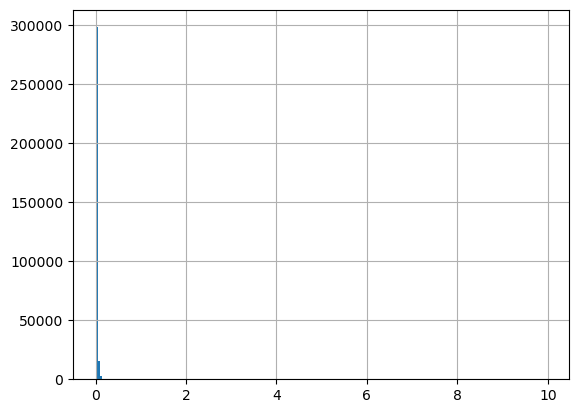

In [26]:
df_train.score.hist(bins=200)

<Axes: >

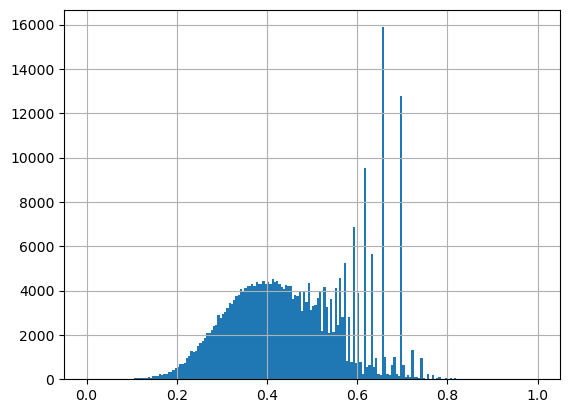

In [27]:
df_train.log_score.hist(bins=200)

In [28]:
# df_train_sim = df_train.copy()
# df_train_sim.rel_product_id = df_train_sim.source_product_id
# df_train_sim.log_score = 1
# df_train_sim

In [29]:
df_train_dis = df_train.copy()
df_train_dis.rel_product_id = df_train_dis.source_product_id.sample(frac=1).values
df_train_dis.log_score = 0
df_train_dis

source_product_id  rel_product_id     score  log_score
64895             8414454         4724496  0.034483          0
13189            10198335         1644110  0.011494          0
141412           11911889        11270864  0.034483          0
71301             6413579         5060876  0.005445          0
45636              435322        12273438  0.001014          0
...                   ...             ...       ...        ...
96762            11346304         9993881  1.764566          0
11591             7910844          481761  0.000046          0
82483            12662662         1590302  0.008621          0
77594             4575263         7245934  0.001301          0
29407            10664369        11562239  0.000575          0

[317244 rows x 4 columns]

In [30]:
df_train = pd.concat([df_train, df_train_dis], axis=0).sample(frac=1)
df_train

source_product_id  rel_product_id     score  log_score
119677           11346304         9478055  0.002653   0.000000
83745             2241658         9779469  0.000530   0.000000
87424             9586492         3555139  0.137931   0.741757
6701             11138726        10885132  0.002653   0.503378
16969             3537422         9332476  0.009852   0.000000
...                   ...             ...       ...        ...
54246             1949397         6661907  0.000556   0.000000
61880             2691925         7821060  0.034483   0.658122
96651            11228214         5130719  0.011494   0.591842
21820            11234013         4876058  0.000059   0.000000
28557             9669100         9637443  0.000034   0.000000

[634488 rows x 4 columns]

# TF Dataset

In [37]:
# tab Pipline
ds_tab_source = tf.data.Dataset.from_tensor_slices(df_id2feat.loc[df_train.source_product_id].values.tolist())
ds_tab_rel = tf.data.Dataset.from_tensor_slices(df_id2feat.loc[df_train.rel_product_id].values.tolist())
ds_cnn_source = 

In [38]:
for i in ds_tab_source.take(2):
    print(i)

tf.Tensor(
[[ 8.5314667e-01  1.0000000e+00  1.4000000e+01  1.0000000e+00
  -9.2245266e-03  6.5902144e-01  2.0268822e+00 -1.9845228e-01
   0.0000000e+00 -1.2518170e-01 -8.2872182e-02  6.9011247e-01]
 [ 1.6853271e-01  1.2140000e+03  1.2700000e+02  0.0000000e+00
  -9.2245266e-03 -3.2001781e-01 -6.8044975e-02  5.0389948e+00
   0.0000000e+00 -1.2518170e-01 -8.2872182e-02 -1.1242117e-01]], shape=(2, 12), dtype=float32)
tf.Tensor(
[[ 7.2081953e-01  1.1000000e+02  7.0900000e+02  0.0000000e+00
  -9.2245266e-03  2.2389287e-01 -2.6417401e-01 -1.9845228e-01
   0.0000000e+00 -1.2518170e-01 -8.2872182e-02 -9.9984609e-02]
 [ 8.3753806e-01  6.4100000e+02  1.2700000e+02  0.0000000e+00
  -9.2245266e-03  7.6780355e-01 -2.8340235e-01 -1.9845228e-01
   0.0000000e+00 -1.2518170e-01 -8.2872182e-02 -1.0481986e-01]], shape=(2, 12), dtype=float32)


# Model

In [38]:
df_id2feat

id  category  brand  is_premium  is_miscellaneous  r_rate  \
350          350.0         1     15       False               0.0    0.96   
1895        1895.0         8     29       False               0.0    0.82   
2739        2739.0        33     50       False               0.0    0.84   
2746        2746.0        33     50       False               0.0    0.82   
2747        2747.0        33     50       False               0.0    0.86   
...            ...       ...    ...         ...               ...     ...   
2071563  2071563.0       484   2484       False               0.0    0.86   
2071605  2071605.0       209    127       False               0.0    0.70   
2071615  2071615.0       484   2484       False               0.0    0.86   
2072202  2072202.0       605    127       False               0.0    0.74   
2072238  2072238.0       206    127       False               0.0    0.82   

          r_count  is_fake  is_jet  is_med  has_size_guide     price  
350      0.000834      0.0     0.0     0.0             0.0  0.007356  
1895     0.005740      0.0     0.0     0.0             0.0  0.000211  
2739     0.005673      0.0     0.0     0.0             0.0  0.000300  
2746     0.005556      0.0     0.0     0.0             0.0  0.000233  
2747     0.008910      0.0     0.0     0.0             0.0  0.000325  
...           ...      ...     ...     ...             ...       ...  
2071563  0.005256      0.0     0.0     0.0             0.0  0.000077  
2071605  0.001602      0.0     0.0     0.0             0.0  0.000078  
2071615  0.015451      0.0     0.0     0.0             0.0  0.000076  
2072202  0.017019      0.0     0.0     0.0             0.0  0.000081  
2072238  0.000684      0.0     0.0     0.0             0.0  0.001639  

[70518 rows x 12 columns]

In [ ]:
df_train.source_product_id.apply(lambda x:df_id2feat.loc[x]).iloc[:,1:]

In [23]:
a = np.expand_dims(np.asarray(Image.open('DATA/Images/10000236.png')), axis=0)

In [31]:
ACTIVATION = 'relu'
UNITS = [512,128,64,32]
REGUL = tf.keras.regularizers.L2(0.005)
D_RATE = 0.05

In [32]:
def get_tab_model(name = 'tabular_model'):
    # Tabular
    input_tab = tf.keras.Input(shape=(12,), name = 'tab_in')
    input_ids = input_tab[:,0:1]
    input_cat = input_tab[:,1:2]
    input_bra = input_tab[:,2:3]
    input_rest = input_tab[:,3:]
    
    cat = layers.Embedding(df_id2feat.category.nunique(), 16, input_length=1)(input_cat)
    cat = layers.Flatten()(cat)

    bra = layers.Embedding(df_id2feat.brand.nunique(), 16, input_length=1)(input_bra)
    bra = layers.Flatten()(bra)

    tab_out = layers.Concatenate()([input_ids, input_rest, cat, bra])

    for u in UNITS:
        #tab_out = layers.BatchNormalization()(tab_out)
        tab_out = layers.Dense(u, activation=ACTIVATION, kernel_regularizer=REGUL)(tab_out)
        tab_out = layers.Dropout(D_RATE)(tab_out)
    
#     # model
#     x = layers.Concatenate()([tab_out,cnn_out])
#     x = layers.Dense(32)(x)
#     x = tf.linalg.l2_normalize(x, axis=1)
    
    model = models.Model(input_tab, tab_out, name=name)
    
    return model

In [33]:
def get_cnn_model(name = 'cnn_model'):
    cnn_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(224,224,3),
        alpha=1.0,
        minimalistic=False,
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        classes=1000,
        pooling=None,
        dropout_rate=0.2,
        classifier_activation='softmax',
        include_preprocessing=True
    )
    # Images
    input_cnn = tf.keras.Input(shape=(224,224,3), name = 'cnn_in')
    cnn_out = cnn_model(input_cnn)
    cnn_out = layers.Flatten()(cnn_out)
    for u in UNITS:
        cnn_out = layers.Dense(u, activation=ACTIVATION, kernel_regularizer=REGUL)(cnn_out)
        cnn_out = layers.Dropout(D_RATE)(cnn_out)
        
    model = models.Model(input_cnn, cnn_out, name=name)
    
    return model
    

In [34]:
tf.keras.backend.clear_session()
tab_model = get_tab_model()
cnn_model = get_cnn_model()

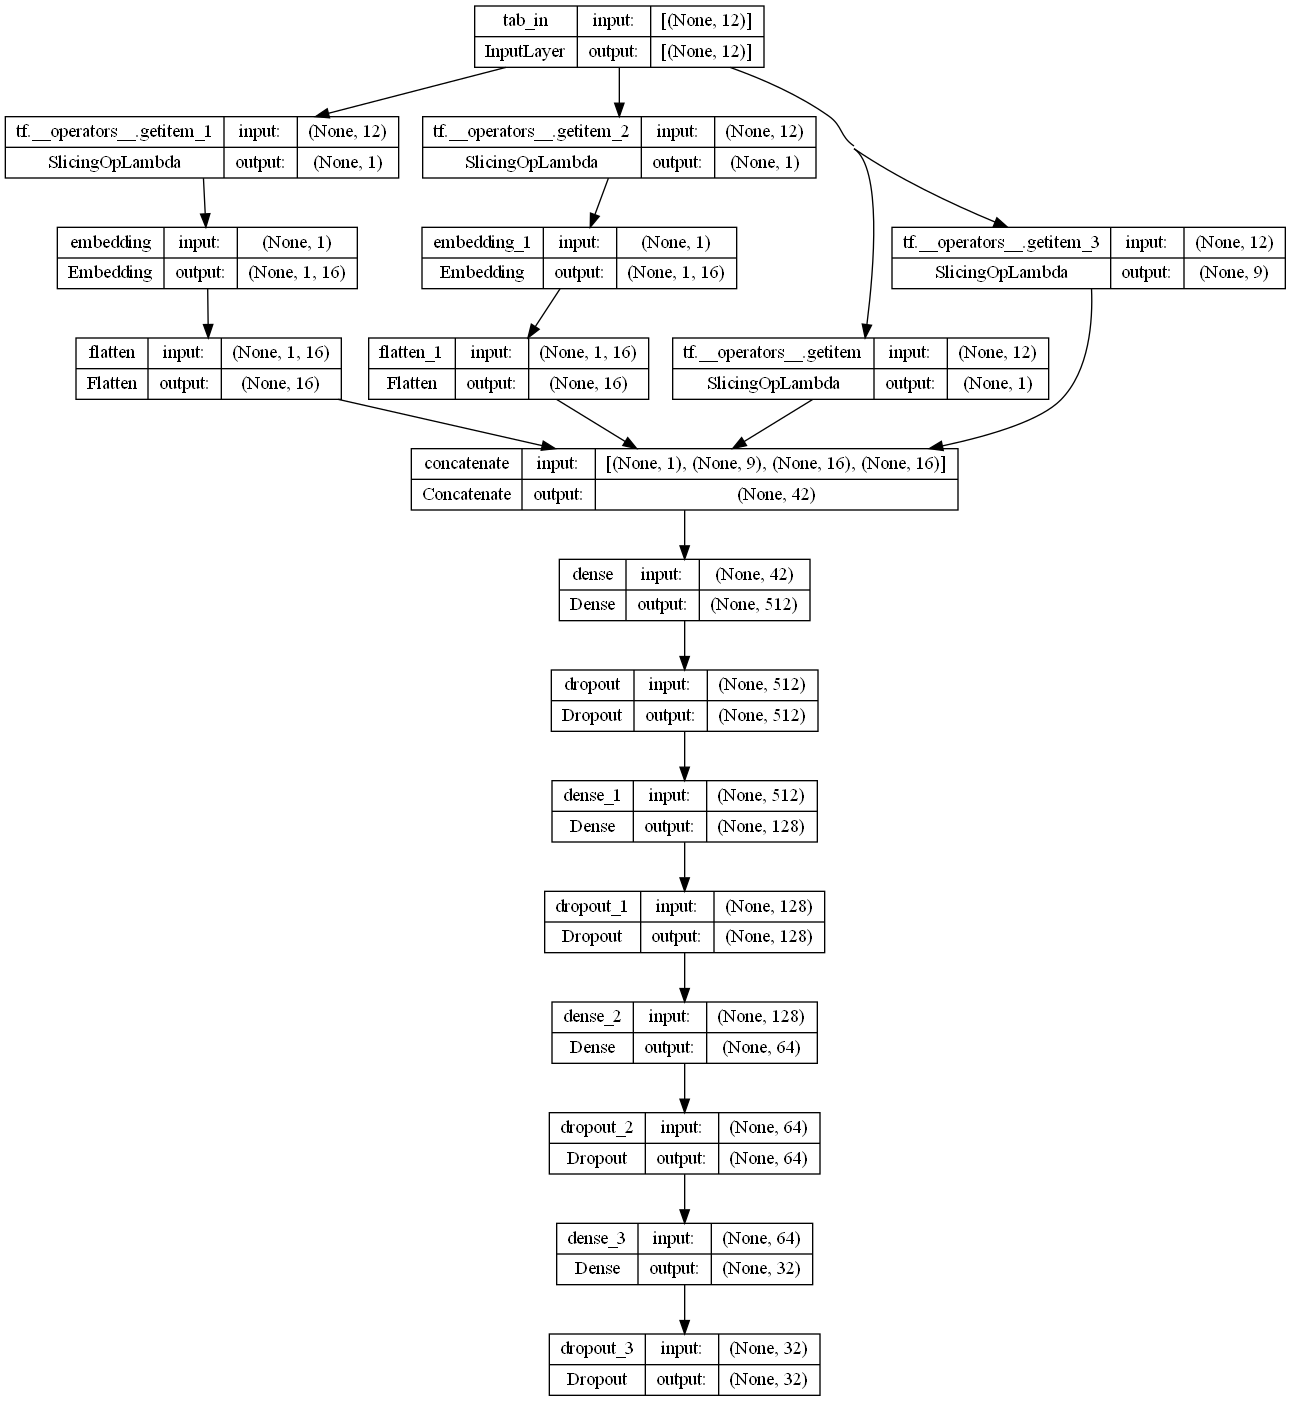

In [35]:
tf.keras.utils.plot_model(tab_model, show_shapes=True)

In [133]:
source_cnn_in = tf.keras.Input((224,224,3), name='source_cnn_in')
source_cnn_out = cnn_model(source_cnn_in)

rel_cnn_in = tf.keras.Input((224,224,3), name='rel_cnn_in')
rel_cnn_out = cnn_model(rel_cnn_in)

source_tab_in = tf.keras.Input((11,), name='source_tab_in')
source_tab_out = tab_model(source_tab_in)

rel_tab_in = tf.keras.Input((11,), name='rel_tab_in')
rel_tab_out = tab_model(rel_tab_in)

source_vec = layers.Concatenate()([source_tab_out, source_cnn_out])
rel_vec = layers.Concatenate()([rel_tab_out, rel_cnn_out])

output = layers.Dot(axes=1)([source_vec,rel_vec])


#x = layers.Dense(1)(x)

model = models.Model([source_tab_in, source_cnn_in, rel_tab_in, rel_cnn_in], output)

model.compile(optimizer=optimizers.Adam(0.0001), loss=losses.BinaryCrossentropy(), metrics=metrics.RootMeanSquaredError())

In [134]:
model.summary(expand_nested=True)              

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_tab_in (InputLayer)     [(None, 11)]         0           []                               
                                                                                                  
 source_cnn_in (InputLayer)     [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rel_tab_in (InputLayer)        [(None, 11)]         0           []                               
                                                                                                  
 rel_cnn_in (InputLayer)        [(None, 224, 224, 3  0           []                           

||                                                                                              ||
|| expanded_conv/depthwise/pad (Z  (None, 113, 113, 16  0      []                               ||
|| eroPadding2D)              )                                                                 ||
||                                                                                              ||
|| expanded_conv/depthwise (Depth  (None, 56, 56, 16)  144     []                               ||
|| wiseConv2D)                                                                                  ||
||                                                                                              ||
|| expanded_conv/depthwise/BatchN  (None, 56, 56, 16)  64      []                               ||
|| orm (BatchNormalization)                                                                     ||
||                                                                                              ||
|| re_lu_1

|| D)                                                                                           ||
||                                                                                              ||
|| expanded_conv_2/project/BatchN  (None, 28, 28, 24)  96      []                               ||
|| orm (BatchNormalization)                                                                     ||
||                                                                                              ||
|| expanded_conv_2/Add (Add)  (None, 28, 28, 24)   0           []                               ||
||                                                                                              ||
|| expanded_conv_3/expand (Conv2D  (None, 28, 28, 96)  2304    []                               ||
|| )                                                                                            ||
||                                                                                              ||
|| expande

|| tf.math.multiply_5 (TFOpLambda  (None, 14, 14, 240)  0      []                               ||
|| )                                                                                            ||
||                                                                                              ||
|| multiply_3 (Multiply)      (None, 14, 14, 240)  0           []                               ||
||                                                                                              ||
|| expanded_conv_4/depthwise (Dep  (None, 14, 14, 240)  6000   []                               ||
|| thwiseConv2D)                                                                                ||
||                                                                                              ||
|| expanded_conv_4/depthwise/Batc  (None, 14, 14, 240)  960    []                               ||
|| hNorm (BatchNormalization)                                                                   ||
||        

|| multiply_6 (Multiply)      (None, 14, 14, 240)  0           []                               ||
||                                                                                              ||
|| expanded_conv_5/squeeze_excite  (None, 1, 1, 240)  0        []                               ||
|| /AvgPool (GlobalAveragePooling                                                               ||
|| 2D)                                                                                          ||
||                                                                                              ||
|| expanded_conv_5/squeeze_excite  (None, 1, 1, 64)  15424     []                               ||
|| /Conv (Conv2D)                                                                               ||
||                                                                                              ||
|| expanded_conv_5/squeeze_excite  (None, 1, 1, 64)  0         []                               ||
|| /Relu (

||                                                                                              ||
|| tf.math.multiply_13 (TFOpLambd  (None, 1, 1, 120)  0        []                               ||
|| a)                                                                                           ||
||                                                                                              ||
|| expanded_conv_6/squeeze_excite  (None, 14, 14, 120)  0      []                               ||
|| /Mul (Multiply)                                                                              ||
||                                                                                              ||
|| expanded_conv_6/project (Conv2  (None, 14, 14, 48)  5760    []                               ||
|| D)                                                                                           ||
||                                                                                              ||
|| expande

|| tf.__operators__.add_17 (TFOpL  (None, 14, 14, 288)  0      []                               ||
|| ambda)                                                                                       ||
||                                                                                              ||
|| re_lu_22 (ReLU)            (None, 14, 14, 288)  0           []                               ||
||                                                                                              ||
|| tf.math.multiply_17 (TFOpLambd  (None, 14, 14, 288)  0      []                               ||
|| a)                                                                                           ||
||                                                                                              ||
|| multiply_11 (Multiply)     (None, 14, 14, 288)  0           []                               ||
||                                                                                              ||
|| expande

||                                                                                              ||
|| re_lu_26 (ReLU)            (None, 7, 7, 576)    0           []                               ||
||                                                                                              ||
|| tf.math.multiply_21 (TFOpLambd  (None, 7, 7, 576)  0        []                               ||
|| a)                                                                                           ||
||                                                                                              ||
|| multiply_14 (Multiply)     (None, 7, 7, 576)    0           []                               ||
||                                                                                              ||
|| expanded_conv_9/squeeze_excite  (None, 1, 1, 576)  0        []                               ||
|| /AvgPool (GlobalAveragePooling                                                               ||
|| 2D)    

|| e/Conv_1 (Conv2D)                                                                            ||
||                                                                                              ||
|| tf.__operators__.add_25 (TFOpL  (None, 1, 1, 576)  0        []                               ||
|| ambda)                                                                                       ||
||                                                                                              ||
|| re_lu_30 (ReLU)            (None, 1, 1, 576)    0           []                               ||
||                                                                                              ||
|| tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)  0        []                               ||
|| a)                                                                                           ||
||                                                                                              ||
|| expande

In [135]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [27]:
checking = df_id2feat.iloc[:2, 1:].values.astype(float)
model.predict([checking, checking])

1/1 [==============================] - 1s 1s/step


array([[1.0000002 ],
       [0.99999994]], dtype=float32)

In [28]:
checking

array([[1.00000000e+00, 1.50000000e+01, 0.00000000e+00, 0.00000000e+00,
        9.60000000e-01, 8.34264929e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.41388908e-04],
       [8.00000000e+00, 2.90000000e+01, 0.00000000e+00, 0.00000000e+00,
        8.20000000e-01, 5.73974271e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.11055567e-04]])

In [29]:
x1 = df_train.source_product_id.apply(lambda x:df_id2feat.loc[x]).iloc[:,1:]
x2 = df_train.rel_product_id.apply(lambda x:df_id2feat.loc[x]).iloc[:,1:]
y = df_train.log_score


MemoryError: Unable to allocate 2.42 MiB for an array with shape (317244,) and data type int64

In [ ]:
pd.concat([x1,x2,y], axis=1)

In [ ]:
# weights = 1/df_train.score.map(df_train.score.value_counts(normalize=True))
# sample_weights = (weights/weights.sum())*df_train.shape[0]

In [ ]:
x1 = x1.values.astype('float')
x2 = x2.values.astype('float')

In [ ]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model.fit(
    x=(x1,x2),
    y=y,
    batch_size=256,
    epochs=200,
    callbacks=[es],
    validation_split=0.1,
    validation_data=None,
    validation_steps=None,
    validation_batch_size=32,
    #sample_weight=sample_weights.values
)

In [60]:
p = model.predict([x1[:20],x2[:20]])

1/1 [==============================] - 0s 26ms/step


In [61]:
df_train['pred'] = None
df_train['pred'].values[:20] = p.squeeze()

In [62]:
df_train

source_product_id  rel_product_id     score  log_score      pred
0                    3026        10752088  0.000522   0.405359  0.991222
1                    3914        10638411  0.000036   0.243182  0.669036
2                   14774          310305  0.022989   0.633660  0.979412
3                   14774        11411577  0.006897   0.561024  0.979807
4                   20855         2025918  0.001389   0.464330   0.99849
...                   ...             ...       ...        ...       ...
158617           12549554        12614281  0.000406   0.390096      None
158618           12557210         9219863  0.017241   0.616304      None
158619           12607485          214900  0.000113   0.312817      None
158620           12672861         8963092  0.000601   0.413782      None
158621           12673045        13074101  0.000333   0.378216      None

[158622 rows x 5 columns]

<Axes: >

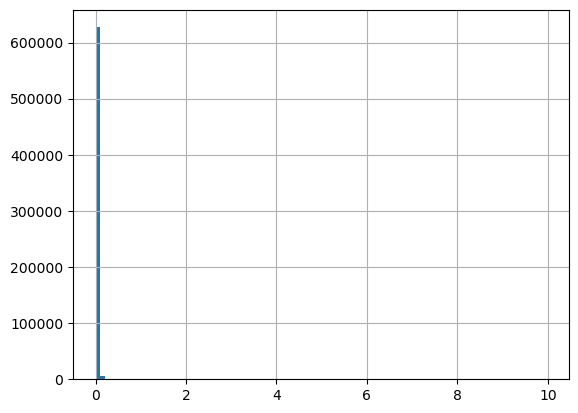

In [46]:
df_train.score.hist(bins = 100)

# Submit

In [50]:
feat_vec = s_model.predict(df_id2feat.iloc[:,1:].values)
df_vec = pd.DataFrame(feat_vec, index=df_id2feat.index)

2204/2204 [==============================] - 4s 2ms/step


In [51]:
df_vec

0         1         2         3         4         5         6   \
350      0.293067 -0.121238  0.331524 -0.112529  0.118170 -0.260136 -0.128173   
1895     0.192979 -0.098935  0.500648 -0.263503 -0.203782  0.270093 -0.100811   
2739     0.413213 -0.205948 -0.208232  0.054103  0.152646 -0.175089  0.506038   
2746     0.415376 -0.208251 -0.207890  0.054697  0.151115 -0.173745  0.505032   
2747     0.411019 -0.203690 -0.208522  0.053487  0.154652 -0.176497  0.506610   
...           ...       ...       ...       ...       ...       ...       ...   
2071563 -0.221902 -0.209179  0.026527 -0.211192 -0.177241 -0.331306 -0.034801   
2071605  0.090739 -0.329719  0.254063 -0.220548  0.427326 -0.000791  0.005330   
2071615 -0.221878 -0.209026  0.026411 -0.211386 -0.176702 -0.331539 -0.034814   
2072202 -0.228258 -0.078104 -0.146080 -0.456035  0.443924  0.140567 -0.246433   
2072238  0.144679 -0.272583 -0.351684 -0.044655  0.135002  0.087157 -0.189806   

               7         8         9         10        11        12        13  \
350      0.508603 -0.344787  0.128837 -0.325872 -0.030772  0.295236  0.072048   
1895     0.252628 -0.117604 -0.141756  0.116341  0.064875  0.510306  0.248052   
2739    -0.078047 -0.182432  0.311036  0.105379  0.262396  0.233316 -0.068275   
2746    -0.080162 -0.182114  0.310921  0.104878  0.262301  0.232708 -0.069057   
2747    -0.075880 -0.182267  0.311291  0.105944  0.262780  0.233638 -0.067352   
...           ...       ...       ...       ...       ...       ...       ...   
2071563 -0.001246  0.208924  0.285645  0.299786  0.342613  0.197325 -0.294976   
2071605  0.217188  0.539388 -0.435559 -0.032216  0.054008  0.044923 -0.092345   
2071615 -0.000679  0.209031  0.285578  0.299961  0.342607  0.197020 -0.294801   
2072202  0.026882  0.034776 -0.103773  0.144840 -0.139430  0.137599 -0.537511   
2072238 -0.301933 -0.097726  0.330257 -0.141538 -0.030620  0.191972 -0.449479   

               14        15  
350     -0.086352  0.278699  
1895    -0.219178  0.150920  
2739    -0.394059 -0.008295  
2746    -0.393360 -0.009329  
2747    -0.395187 -0.007447  
...           ...       ...  
2071563 -0.454803 -0.232412  
2071605 -0.208771  0.036302  
2071615 -0.455103 -0.232152  
2072202  0.197257  0.187222  
2072238 -0.493944 -0.060198  

[70518 rows x 16 columns]

In [171]:
df_test.source_product_id.value_counts().sort_values()

source_product_id
9810421     236
5188998     172
7461831     170
9864367     165
8414923     153
           ... 
7861160       1
10348130      1
980724        1
1973356       1
5090960       1
Name: count, Length: 1945, dtype: int64

In [78]:
len(df_nominated.rel_product_id.unique().tolist())

17647

In [88]:
df_vec.loc[i].values@np.tile(np.expand_dims(df_vec.loc[i].values, axis=0), (17647,1)).T

array([0.99999994, 0.99999994, 0.99999994, ..., 0.99999994, 0.99999994,
       0.99999994], dtype=float32)

In [187]:
value_counts = df_test.source_product_id.value_counts()#.sort_values()
nom_id_pool = df_nominated.rel_product_id.to_list()
df_test['rel_product_id'] = None

debug_counter = 0
for i, c in zip(value_counts.index, value_counts.values):
    nom_id_unique = np.unique(nom_id_pool).tolist()
    
    score = (df_vec.loc[i].values@df_vec.loc[nom_id_unique].T).sort_values(ascending=False)
    try: score.drop(labels=[i], inplace=True)
    except: 
        #print(f'No instance of {i} found in nominated list')
        debug_counter += 1
        
    score = score.iloc[:c]
    
    for r in score.index:
        nom_id_pool.remove(r)
    
    df_test.loc[df_test.source_product_id == i, 'rel_product_id'] = score.index
    

In [207]:
# Wrong FIX THIS
nom_id_pool = df_nominated.rel_product_id.to_list()
df_test['rel_product_id'] = None

debug_counter = 0
res = []
for i in df_test['source_product_id'].values:
    score = (df_vec.loc[i].values@df_vec.loc[nom_id_pool].T).sort_values(ascending=False)
    try: score.drop(labels=[i], inplace=True)
    except: 
        #print(f'No instance of {i} found in nominated list')
        debug_counter += 1
    res.append(score.index[0])
    nom_id_pool.remove(score.index[0])
    

In [209]:
score.index[0]

1039165

In [208]:
nom_id_pool

[]

In [162]:
c

170

In [210]:
score

1039165    0.526697
dtype: float32

In [194]:
df_test.to_csv('result2.csv')

In [192]:
df_test

source_product_id rel_product_id
0                   2747         806616
1                   5289        3306896
2                   5289        2550885
3                  26237          29088
4                  26701          26716
...                  ...            ...
24697           12143680        7246507
24698           12180235       12116643
24699           12305148        3595147
24700           12456191        8132989
24701           12557210        8866375

[24702 rows x 2 columns]

In [193]:
pd.read_csv('result.csv')

Unnamed: 0  source_product_id  rel_product_id
0               0               2747          806616
1               1               5289         3306896
2               2               5289         2550885
3               3              26237           29088
4               4              26701           26716
...           ...                ...             ...
24697       24697           12143680         7246507
24698       24698           12180235        12116643
24699       24699           12305148         3595147
24700       24700           12456191         8132989
24701       24701           12557210         8866375

[24702 rows x 3 columns]